# Identifying potential Bot or Paid reviewers using Amazon customer review data using Network Analysis
**By: SLT11A**
* Abel Johua Cruzada
* James Gonzales

# Executive Summary

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import networkx_abel as nxa

import regex as re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

# Introduction

# Problem Statement

# Objectives

# Data Description

# Methodology

# Data Preprocessing

## Filtering

Only include data from 2015 onwards.

In [11]:
df = pd.read_csv('amazon_reviews_video_games.csv', index_col=0)

In [17]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


Remove single value columns

In [21]:
df.nunique()

marketplace               1
customer_id          219045
review_id            330966
product_id            32693
product_parent        31366
product_title         27053
product_category          1
star_rating               5
helpful_votes           183
total_votes             246
vine                      2
verified_purchase         2
review_headline      137990
review_body          259517
review_date             243
dtype: int64

In [22]:
df.drop(['marketplace', 'product_category', 'vine'], axis=1, inplace=True)

## Text Preprocessing

In [26]:
reviews = df.review_body.copy()

In [34]:
reviews.iloc[3]

'nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.'

Set stopwords and contractions

In [25]:
stop_words = stopwords.words('english')
CONTRACTIONS = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will",
    "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as",
    "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not",
    "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [73]:
def text_cleaner(text):
    """
    Cleans the text by removing dates and comments.
    i.e. text enclosed in brackets and parenthesis.
    Expand contractions and remove punctations.

    Parameters
    ----------
    text : str
        Text to clean.

    Return
    ------
    token : list of str
        Tokens extracted from text after cleaning.
    """
    month_pattern = (r'jan[\w]+ |feb[\w]+ |mar[\w]+ |apr[\w]+ |may |jun[\w]+ '
                     r'|jul[\w]+ |aug[\w]+ |sep[\w]+ |oct[\w]+ |nov[\w]+ '
                     r'|dec[\w]+ ')

    clean_text = text.lower()
    clean_text = re.sub(r'[\(\)\[\]\{\}]', ' ', clean_text)
    clean_text = re.sub(month_pattern, ' ', clean_text)
    clean_text = re.sub(r'"', '', clean_text)
    clean_text = re.sub(r"'s\b", ' ', clean_text)
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(r'[\ ]+', ' ', clean_text)

    clean_text = ' '.join([CONTRACTIONS[t] if t in CONTRACTIONS else t
                           for t in clean_text.split(' ')])

    return simple_preprocess(clean_text, deacc=True, min_len=2)


def remove_stopwords(words, stop_words=stop_words):
    """
    Remove stop words from the list of words.

    Parameters
    ----------
    words : list of str
        Words to remove stop words.
    stop_words : set of str
        Words to remove.

    Returns
    -------
    token : list of str
        Tokens with removed stop words.
    """
    return [word for word in words if not word in stop_words]

In [74]:
reviews_clean = reviews.apply(lambda x: text_cleaner(str(x)))
reviews_clean = reviews_clean.apply(remove_stopwords)

# EDA

In [97]:
print(('Overall there are {} different products and variations out of {} '
       'reviews in our dataset.')
      .format(df.product_id.nunique(), df.shape[0]))

Overall there are 32693 different products and variations out of 330966 reviews in our dataset.


In [91]:
prod_counts = df.product_title.value_counts().copy()

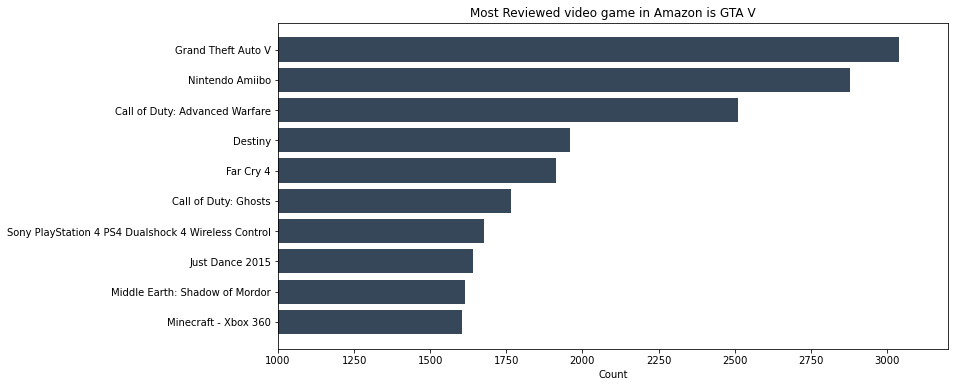

In [92]:
top10_prod = prod_counts.head(10)
top10_prod.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh(top10_prod.index, top10_prod, color='#37475a')
plt.title('Most Reviewed video game in Amazon is GTA V')
plt.xlabel('Count')
plt.xlim((1000, 3200))
plt.show()

The most extremely popular videogame in our dataset is GTA V and Nintendo Amiibo. With numerous reviews, it can gain the trust of potential customers based on the reviews in search of reliable opinion. Hence, it can further lead to increase in sales for the particular product.

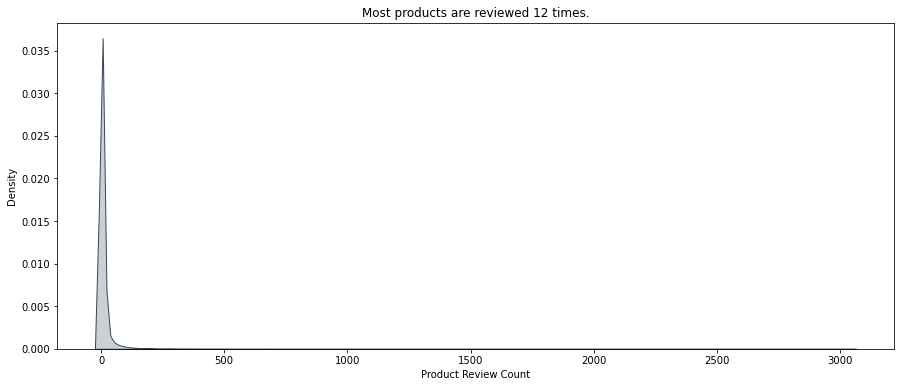

In [109]:
plt.figure(figsize=(15, 6))
sns.kdeplot(prod_counts, shade=True, color='#37475a')
plt.title(f'Most products are reviewed {int(prod_counts.mean())} times.')
plt.xlabel('Product Review Count')
plt.show()

The plot above shows that rightly skewed distribution of product review counts. Some products are extremely popular reaching a scale of a thousand reviews, showcasing its reliability (because of many buyers/reviewers). In comparison, most of the products in the dataset are only reviewed around 12 times.

## Barplot Verified purchase

## Barplot Customer Review Frequency

## Barplot Star Rating, Helpful Votes, Total Votes

In [89]:
clean_text = text_cleaner('nice,thank you')
print(clean_text)
remove_stopwords(clean_text)

['nice', 'thank', 'you']


['nice', 'thank']

* Remove Stopwords, High Frequency Words.
* Tokenization

# FIM

customer1: {product1, product2, product3},

customer2: {product1, product2, product4}

## Confidence, Lift, Covariance

# Network

## Construct the Network

Color code based on 5 rating, scale the size of the node based on number of degrees, change the weight of the links based on prevalence of reviewed products.

## Network Properties

## Centrality Measurements

## Community Detection

# Review Information Network

Co-occurrence of words in the review.

## Convert to Word2Vec

## Cosine Similarity

## Clustering

## Customer Review Frame Network

# Conclusion

# Recommendation

# Reference